In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('data/diabetes.csv')

In [2]:
df.columns = df.columns.str.lower()

In [3]:
# Imputing the zeros in columns with the mean of the nonzero entries
df['glucose'].replace(0, df[df['glucose']>0].loc[:,'glucose'].mean(), inplace=True)
df['bloodpressure'].replace(0, df[df['bloodpressure']>0].loc[:,'bloodpressure'].mean(), inplace=True)
df['insulin'].replace(0, df[df['insulin']>0].loc[:,'insulin'].mean(), inplace=True)
df['bmi'].replace(0, df[df['bmi']>0].loc[:,'bmi'].mean(), inplace=True)
df['skinthickness'].replace(0, df[df['skinthickness']>0].loc[:,'skinthickness'].mean(), inplace=True)
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


## Parameters and useful functions for analysis

In [4]:
def summary_of_model(clf, X_train, X_test, y_train, y_test, threshold):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
    # This provides a summary of the model given a certain decision threshold of the predicted probability.
    # It includes a summary on recall/accuracy on the training and test sets, a visual display of the confusion matrix
    # and a plot of the precision-recall curve for a given classifier.
    pred_proba_test = clf.predict_proba(X_test)
    pred_test = (pred_proba_test [:,1] >= threshold).astype('int')
    pred_proba_train = clf.predict_proba(X_train)
    pred_train = (pred_proba_train [:,1] >= threshold).astype('int')
    print(classification_report(y_test, pred_test))
    print('Recall of diabetes on the training set: {:.2f}'.format(recall_score(y_train, pred_train)))
    print('Accuracy on the training set: {:.2f}'.format(accuracy_score(y_train, pred_train)))
    print('Recall of diabetes class on the test set: {:.2f}'.format(recall_score(y_test, pred_test)))
    print('Accuracy on the test set: {:.2f}'.format(accuracy_score(y_test, pred_test)))
    print(confusion_matrix(y_test, pred_test))
    # Make a more legible confusion matrix
    _, ax = plt.subplots(figsize=(9,9))
    ax = sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='d', cmap='vlag', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['False', 'True']
    ax.set_xticklabels(labels, fontsize=25);
    ax.set_yticklabels(labels, fontsize=25);
    ax.set_ylabel('Actual', fontsize=30);
    ax.set_xlabel('Prediction', fontsize=30)
    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    plt.figure()
    plt.plot(lr_recall, lr_precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [5]:
def summary_of_model_nothresh(clf, X_train, X_test, y_train, y_test):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
    # This provides a summary of the model, but without the threshold condition.
    # It includes a summary on recall/accuracy on the training and test sets, a visual display of the confusion matrix
    # and a plot of the precision-recall curve for a given classifier.
    pred_test = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    print(classification_report(y_test, pred_test))
    print('Recall of diabetes on the training set: {:.2f}'.format(recall_score(y_train, pred_train)))
    print('Accuracy on the training set: {:.2f}'.format(accuracy_score(y_train, pred_train)))
    print('Recall of diabetes class on the test set: {:.2f}'.format(recall_score(y_test, pred_test)))
    print('Accuracy on the test set: {:.2f}'.format(accuracy_score(y_test, pred_test)))
    print(confusion_matrix(y_test, pred_test))
    _, ax = plt.subplots(figsize=(9,9))
    ax = sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='d', cmap='vlag', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['False', 'True']
    ax.set_xticklabels(labels, fontsize=25);
    ax.set_yticklabels(labels, fontsize=25);
    ax.set_ylabel('Actual', fontsize=30);
    ax.set_xlabel('Prediction', fontsize=30)
    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    plt.figure()
    plt.plot(lr_recall, lr_precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [6]:
from sklearn.metrics import make_scorer
def recall_calc(y_true, y_pred):
    # A calculator for the recall of diabetes. There is a built-in function for this, but I wanted to verify the built-in.
    y_true = y_true.values
    #y_pred = y_pred.values
    true_positives = np.array([1 if (y_true[i]==1 and y_pred[i]==1) else 0 for i in np.arange(0,len(y_true))])
    false_negatives = np.array([1 if (y_true[i]==1 and y_pred[i]==0) else 0 for i in np.arange(0,len(y_true))])
    recall = true_positives.sum()/(true_positives.sum() + false_negatives.sum())
    return recall

In [7]:
def find_threshold(clf, y_test, X_test):
    # A function that finds the highest (up to descritization) probability threshold (or decision boundary) that has a recall 
    # of req_recall. 
    req_recall = .8
    threshold = .5
    pred_proba_test = clf.predict_proba(X_test)
    pred_test = (pred_proba_test [:,1] >= threshold).astype('int')
    search_step = 1e-2 # the amount to decrease the probabilty threshold if the recall is not > .8
    current_recall = recall_calc(y_test, pred_test)
    while(current_recall < req_recall):
        threshold = threshold - search_step
        pred_proba_test = clf.predict_proba(X_test)
        pred_test = (pred_proba_test [:,1] >= threshold).astype('int')
        current_recall = recall_calc(y_test, pred_test)
    return threshold

## Feature Setup, Scale Data

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #scaling the parameters
ss = StandardScaler()
cols_to_scale = ['pregnancies', 'age', 'bmi', 'diabetespedigreefunction', 'bloodpressure', 'insulin', 'glucose']# cols not included: 'age', 'pregnancies', 'glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction',  'bloodpressure','skinthickness'
cols_not_scaled = ['outcome']
#pd.pivot_table(df, index=['outcome'],  values = df.columns, aggfunc = np.mean)
df_scaled = pd.DataFrame(ss.fit_transform(df[cols_to_scale]), index=df.index, columns=cols_to_scale)
df_scaled[cols_not_scaled] = df[cols_not_scaled]
pd.pivot_table(df_scaled, index=['outcome'],  values = df_scaled.columns, aggfunc = np.mean)

,age,bloodpressure,bmi,diabetespedigreefunction,glucose,insulin,pregnancies
outcome,,,,,,,
0,-0.174505,-0.121586,-0.228366,-0.127275,-0.360882,-0.156975,-0.162456
1,0.325569,0.226839,0.426056,0.237453,0.673288,0.292863,0.303090


In [9]:
from random import randrange
from sklearn.model_selection import train_test_split
TEST_FRACTION = .25 #percentage of the test size
CV = 7 #cross validations to do in grid search
OPT_ON = 'f1' #what to optimize in gridsearches
N_JOBS = 5 #number of cores
RAND_STATE = 0 #will be doing multiple train-test-splits, and want to keep everything random, but do the same train-test-splits

In [10]:
y=df_scaled.pop('outcome')
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=TEST_FRACTION, random_state = RAND_STATE)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
>>> from sklearn.model_selection import GridSearchCV
grid_values_boost = {'n_estimators': [100, 200, 300, 400, 500],
                     'learning_rate': [1e-3, 2e-3, 3e-3, 4e-3, 5e-3], 
                     'max_depth': [2, 3]}
clf_boost = GradientBoostingClassifier(random_state = RAND_STATE)
grid_clf_boost = GridSearchCV(clf_boost, param_grid=grid_values_boost, cv=CV, scoring=OPT_ON, n_jobs=N_JOBS, verbose=2)
grid_clf_boost.fit(X_train, y_train)

Fitting 7 folds for each of 50 candidates, totalling 350 fits


GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=5,
             param_grid={'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005],
                         'max_depth': [2, 3],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='f1', verbose=2)

In [12]:
print('Best Params: {}, \n Best score: {}'.format(grid_clf_boost.best_params_, grid_clf_boost.best_score_))

Best Params: {'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 500}, 
 Best score: 0.6185201065325289


In [13]:
thresh = find_threshold(grid_clf_boost, y_train, X_train)
print(thresh)

0.3799999999999999


              precision    recall  f1-score   support

           0       0.87      0.84      0.85       130
           1       0.69      0.74      0.71        62

    accuracy                           0.81       192
   macro avg       0.78      0.79      0.78       192
weighted avg       0.81      0.81      0.81       192

Recall of diabetes on the training set: 0.81
Accuracy on the training set: 0.80
Recall of diabetes class on the test set: 0.74
Accuracy on the test set: 0.81
[[109  21]
 [ 16  46]]


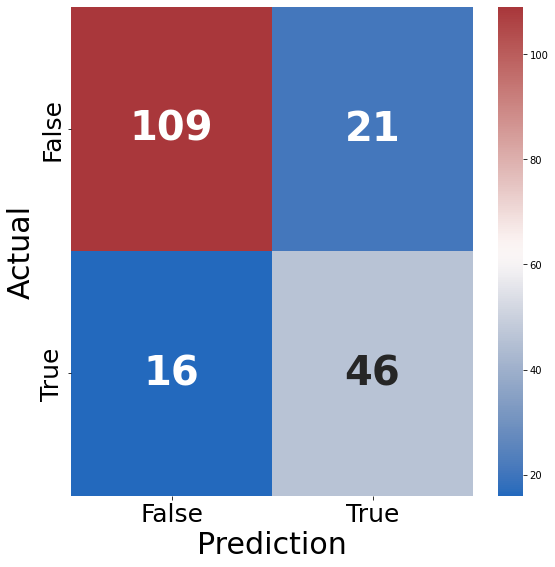

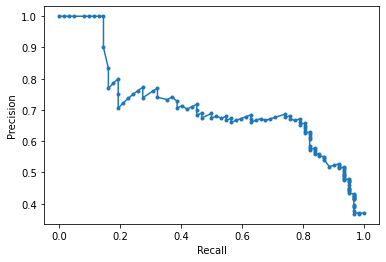

In [14]:
summary_of_model(grid_clf_boost, X_train, X_test, y_train, y_test, thresh)

It may be concerning that the number of true negatives is comparable to the dummy classifier, but I wanted a conservative model and that is a price for that requirement. We have significantly 
increased our recall on diabetes, and our accuracy is still good. But, as a reality check, let's set the threshold to .5 instead of adjusting the threshold
to improve recall.

### Logistic Regression Classifier

In [15]:
from sklearn.linear_model import LogisticRegression
grid_values_log = {'penalty': ['l1','l2'], 'C': np.logspace(-1, 4, 200), 'solver': ['liblinear']}
clf_log = LogisticRegression(random_state = RAND_STATE)
grid_clf_log = GridSearchCV(clf_log, param_grid=grid_values_log, cv=CV, scoring=OPT_ON, n_jobs=N_JOBS, verbose=2)
grid_clf_log.fit(X_train, y_train)

Fitting 7 folds for each of 400 candidates, totalling 2800 fits


GridSearchCV(cv=7, estimator=LogisticRegression(random_state=0), n_jobs=5,
             param_grid={'C': array([1.00000000e-01, 1.05956018e-01, 1.12266777e-01, 1.18953407e-01,
       1.26038293e-01, 1.33545156e-01, 1.41499130e-01, 1.49926843e-01,
       1.58856513e-01, 1.68318035e-01, 1.78343088e-01, 1.88965234e-01,
       2.00220037e-01, 2.12145178e-01, 2.24780583e-01, 2.38168555e-01,
       2.52353917e-01,...
       3.33129479e+03, 3.52970730e+03, 3.73993730e+03, 3.96268864e+03,
       4.19870708e+03, 4.44878283e+03, 4.71375313e+03, 4.99450512e+03,
       5.29197874e+03, 5.60716994e+03, 5.94113398e+03, 6.29498899e+03,
       6.66991966e+03, 7.06718127e+03, 7.48810386e+03, 7.93409667e+03,
       8.40665289e+03, 8.90735464e+03, 9.43787828e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1', verbose=2)

In [16]:
print('Best Params: {}, \n Best score: {:.2f}'.format(grid_clf_log.best_params_, grid_clf_log.best_score_))

Best Params: {'C': 0.40088063288984654, 'penalty': 'l1', 'solver': 'liblinear'}, 
 Best score: 0.64


In [17]:
thresh = find_threshold(grid_clf_log, y_train, X_train)
print(thresh)

0.2999999999999998


              precision    recall  f1-score   support

           0       0.90      0.72      0.80       130
           1       0.59      0.84      0.69        62

    accuracy                           0.76       192
   macro avg       0.75      0.78      0.75       192
weighted avg       0.80      0.76      0.77       192

Recall of diabetes on the training set: 0.81
Accuracy on the training set: 0.73
Recall of diabetes class on the test set: 0.84
Accuracy on the test set: 0.76
[[94 36]
 [10 52]]


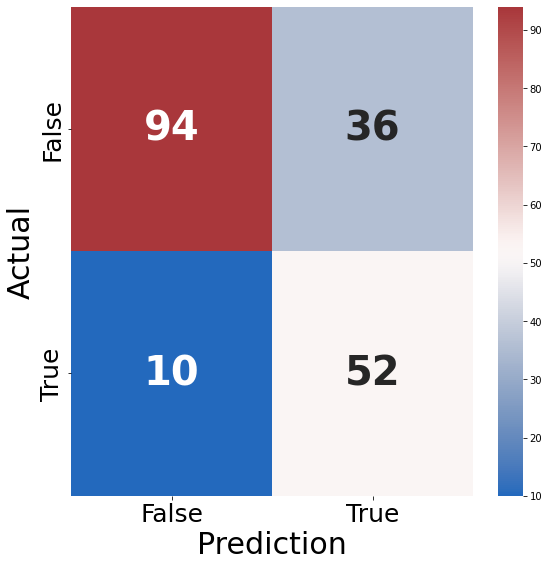

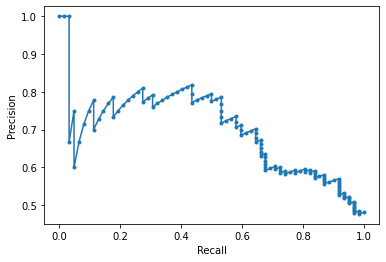

In [18]:
summary_of_model(grid_clf_log, X_train, X_test, y_train, y_test, thresh)